In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO

import matplotlib.pyplot as plt
import matplotlib as mpl

C:\Users\DKR\AppData\Roaming\Python\Python310\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


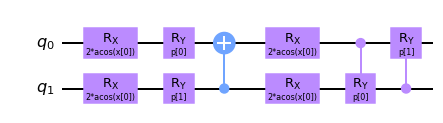

In [2]:
nqubits = 2

qc = QuantumCircuit(2)
p = ParameterVector('p', 2)
x = ParameterVector('x', 1)

qc.rx(2*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)

qc.ry(p[0], 0)
qc.ry(p[1], 1)

qc.cx(1, 0)

qc.rx(2*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)

qc.cry(p[0], 0, 1)
qc.cry(p[1], 1, 0)

pqc = QiskitEncodingCircuit(qc)
pqc.draw()

In [3]:
op = SinglePauli(nqubits,qubit=0,parameterized=False)
print(op)

SparsePauliOp(['IZ'],
              coeffs=[1.+0.j])


In [4]:
op.num_parameters

0

In [5]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13)
param_ini = np.random.rand(pqc.num_parameters)
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
x0 = [[i * 0.02] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.3)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 100}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    #SGLBO(optimizer_options),
    #Adam({"lr": 0.2,"log_file": "adam_noiseless.log"}),
    SLSQP(),
    param_ini,
    param_op_ini,
    opt_param_op=False,
    parameter_seed=124
)

In [6]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.square(x_train)-0.9

In [7]:
def evaluate_loss(param, qnn_regressor: QNNRegressor, X, y):

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, [])

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value




In [8]:
qnn_simulator.fit(x_train, y_train)

fit:   0%|          | 0/100 [00:00<?, ?it/s]param [0.77770241 0.23754122]
loss_value 4.866674761033055
param [-4.20919049 -0.60527017]
loss_value 15.499229582041247
fit:   1%|          | 1/100 [00:00<00:32,  3.07it/s]param [-0.98361889 -0.06013143]
loss_value 6.201199785758219
param [0.01038653 0.10786076]
loss_value 3.2633515520638836
param [-1.62561526  2.37431542]
loss_value 0.8528332557231046
fit:   2%|▏         | 2/100 [00:00<00:32,  3.02it/s]param [-1.04275898  1.57456975]
loss_value 0.13849540897280752
fit:   3%|▎         | 3/100 [00:00<00:27,  3.57it/s]param [-0.90065617  1.55198292]
loss_value 0.07882505793775078
fit:   4%|▍         | 4/100 [00:01<00:24,  3.91it/s]param [-0.83285879  1.66728966]
loss_value 0.032639046878887835
fit:   5%|▌         | 5/100 [00:01<00:23,  4.03it/s]param [-0.78730356  1.74265245]
loss_value 0.02100892266264987
fit:   6%|▌         | 6/100 [00:01<00:27,  3.43it/s]param [-0.75502244  1.77247153]
loss_value 0.019099749847135854
fit:   7%|▋         | 7

In [9]:
qnn_simulator.param

array([-0.71755455,  1.77114475])

In [10]:
evaluate_loss(qnn_simulator.param, qnn_simulator, x_train, y_train)

0.018703564922916967

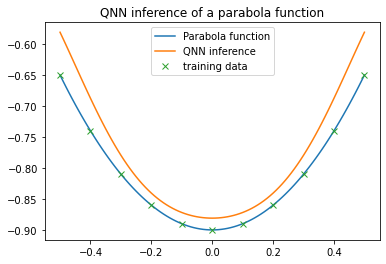

In [11]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.square(x)-0.9, label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

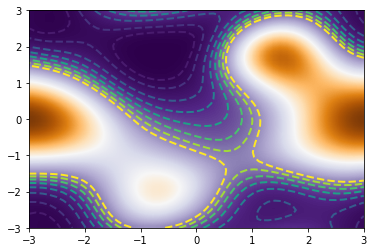

In [12]:
# plot the decision function for each datapoint on the grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 50), np.linspace(-3, 3, 50))
Z = []
for i in range(len(xx)):
    for j in range(len(xx[i])):
        param = np.array([xx[i][j], yy[i][j]])
        Z.append(evaluate_loss(param, qnn_simulator, x_train, y_train))

Z = np.array(Z)
Z = Z.reshape(xx.shape)
#norm = mpl.colors.Normalize(vmin=-max(abs(np.min(Z)),abs(np.max(Z))), vmax=max(abs(np.min(Z)),abs(np.max(Z))))
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    #norm=norm
)
# Plot backtransformed hyperplane
contours = plt.contour(xx, yy, Z, levels=[0,0.5,1,2,3,4,5,6,7], linewidths=2, linestyles="dashed")

# Plot training data
plt.axis([-3, 3, -3, 3])
plt.show()